# Predict and evaluate SkillsColBERT

In [25]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow
#!pip install -U sentence-transformers
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

## Questions:

    a) Dimensions of max function in MaxSim method function.
        - max of column vectors in matrix OR max of row vectors in columns --> 24 dimensional
    b) Training of my ColBERT model
        - [Q] and [D] in vocabulary --> Drop
        - Weights in additional linear layer of 32
        - [MASK] as padding instead of [PAD]
    c) How to save:
        The model (in github) --> Drop
        The document embeddings
        


In [1]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import f1_score
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
# specify CPU or GPU as device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'device = {device}')

device = cpu


In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [4]:
# Load data
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


In [5]:
# Make query embeddings or load them
#q_outputs = torch.tensor(model.encode(df['query'])).to(device)
q_outputs = torch.load(r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')
print(q_outputs.shape)

# Make document embeddings or load them
#d_outputs = torch.tensor(model.encode(df['documents'])).to(device)
d_outputs = torch.load(r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_doc_embeddings_tensor.pt')
print(d_outputs.shape)

#torch.save(q_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')
#torch.save(d_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_doc_embeddings_tensor.pt')

torch.Size([13485, 768])
torch.Size([13485, 768])


# Import model
Queries and documents have now been tokenized to the vocabolary

## Load Query and Document embeddings

In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. 

In my implementation of BERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 768] \\
    dim(E_d) = [ 128 \times 768]
\end{align*}

but with ColBert the last dimension is reduced to 32 by an additional linear layer, such that my implementation of ColBERT, the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_d) = [ 128 \times 32]
\end{align*}

In practice the MaxSim score is implemented such that 1 query is evaluated against all ducuments. Therefore the relevant dimensions are:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_D) = [13.485 \times 128 \times 32]
\end{align*}
where 32 is 768 if standard BERT embeddings are used.


### The relevancy score, MaxSim, is defined as follows:
$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

In [ ]:
def xlmMaxSim(Q,D):
    '''Return the maximum similarity score (maxSim) for all query-document combinations
       and the id (maks_idx) of the most similar document for each query.
    
    Keyword arguments:
    Q -- tensor of all queries' embeddings 
    D -- tensor of all documents' embeddings
    '''
    
    mm = torch.matmul(Q, torch.t(D))
    
    maxSim, maks_idx = torch.max(mm, dim=1) # dim=1 or dim=2

    return maxSim, maks_idx

In [ ]:
def MinEuc(Q, D):
    '''Return the smallest euclidean distance (min_dist) for all query-document combinations
       and the id (min_idx) of the closest document for each query.

        Keyword arguments:
        Q -- tensor of all queries' embeddings 
        D -- tensor of all documents' embeddings
        '''
    
    # Euclidean distance between queries Q against all documents (in D)
    EucDist = torch.cdist(Q, D, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')
    
    min_dist, min_idx = torch.min(EucDist, dim=1) # dim=1 or dim=2
    
    return min_dist, min_idx

## MaxSim implementation

In [109]:
# Calculate MaxSim and assign most similar document ID for each query
maks, maks_idx = xlmMaxSim(Q=q_outputs, D=d_outputs)

# Create query ids (0-13,485)
most_similar_docID = maks_idx
q_IDs = [x for x in range(q_outputs.shape[0])]

# Due to the unchanged order - IDs are also the true labls
y_true = q_IDs
y_pred = most_similar_docID

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),3))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy score
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')


f_1score:  0.149
rights: 2792 out of 13485 
 0.207% accuracy


In [110]:
# Distribution of "predictions"
plt.figure(figsize=(16, 12), dpi=80)
plt.hist(most_similar_docID, bins=q_outputs.shape[0])
plt.title('Distribution of "predictions" of Maximum Similarity')
plt.xlabel('Document ID')
plt.ylabel('No. of predictions')
#plt.ylim(0,100)

plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_MaxSim.png')
plt.show()

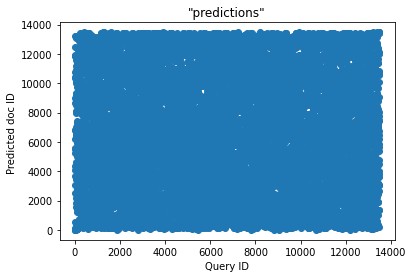

In [48]:
# Distribution of "predictions"
plt.scatter(q_IDs, most_similar_docID)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [12]:
df_correct = df.loc[(np.array(y_true) == np.array(y_pred))]
df_correct

,query,documents
12,udføre gadeinterventioner i forbindelse med so...,Gennemføre outreachaktiviteter ved at give dir...
15,udføre forskning af flora,Indsamle og analysere data om planter med henb...
18,undervise i husholdning,Undervise i såvel husholdning som manuelle fær...
28,producere guitarkomponenter,"Vælg det relevante tonetræ, materialer og værk..."
29,betjene landbrugsmaskiner,"Betjene motordrevet landbrugsudstyr, herunder ..."
...,...,...
13456,overvågningsmetoder,"Overvågningsmetoder, der anvendes til indsamli..."
13463,indsamle husholdningsaffald,Indsamle ikke-farligt affald fra beboelsesområ...
13465,typer af borebits,Egenskaber og anvendelser af forskellige typer...
13471,stofafhængighed,"Afhængighed af stoffer som alkohol, ordineret ..."


## Example of implementation of MINIMUM Eucledian distance

In [ ]:
# Compute euclidean distance and store documents that are close
min_dist, min_idx = MinEuc(Q=q_outputs, D=d_outputs)

# Store in numpy array and create query ids (0-13,485)
most_similar_docID = np.array(min_idx)
q_IDs = [x for x in range(q_outputs.shape[0])]

# Due to the unchanged order - IDs are also the true labls
y_true = q_IDs
y_pred = most_similar_docID

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),3))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')


f_1score:  0.176
rights: 3009 out of 13485 
 0.223% accuracy


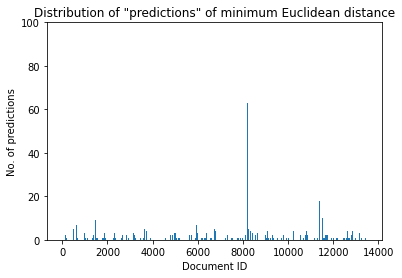

In [101]:
# Distribution of "predictions"
plt.figure(figsize=(16, 12), dpi=80)

plt.hist(most_similar_docID, bins=q_outputs.shape[0])
plt.title('Distribution of predictions of minimum Euclidean distance')
plt.xlabel('Document ID')
plt.ylabel('No. of predictions')
plt.ylim(0,80)

plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_Euclidean.png')
plt.show()

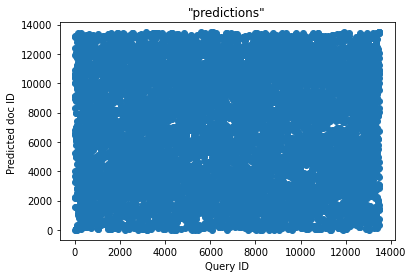

In [19]:
# Distribution of "predictions"
q_IDs = [x for x in range(q_outputs.shape[0])]
plt.scatter(q_IDs, mini_ids)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [18]:
y_true = q_IDs
y_pred = min_idx

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

f_1score:  0.1756
rights: 3009 out of 13485 
 0.223% accuracy


## Play around yourself

In [58]:
def top_k_skills(raw_sentence, D, k=3, df=df):
    '''Return the k documents in df that a raw sentence is most similar to'''
    # Embed senetence
    embeddings = torch.tensor(model.encode(raw_sentence)).to(device)

    # compute similarity score
    mm = torch.matmul(embeddings, torch.t(D))

    # find to k most similar
    maxSim, maks_idx = torch.topk(mm, k, largest=True)
    
    return df.iloc[np.array(maks_idx)]

In [99]:
#kompetence = "samarbejde med andre"
#kompetence = "programmering i sas"
#kompetence = "håndværksfærdigheder"
#kompetence = "anerkendende børnesyn"
#kompetence = "coorporate with others"
kompetence = "god med børn"

top_k_skills(raw_sentence=kompetence, D=d_outputs, k=3, df=df)

,query,documents
5714,implementere plejeprogrammer for børn,Udføre aktiviteter med børn i overensstemmelse...
8813,støtte børns velfærd,"Skabe et miljø, der støtter og værdsætter børn..."
7178,coache unge,Rådgive og coache unge gennem et positivt sams...
